## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [3]:
import pandas as pd

file_name = 'data_000637.txt'
data = pd.read_csv(file_name, nrows=1e5)
data.describe()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
count,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,1.0,0.294840,56.031850,3.869201e+09,1792.946820,13.360150
std,0.0,0.455973,39.118372,2.868888e+02,1025.768294,9.190047
min,1.0,0.000000,1.000000,3.869200e+09,0.000000,0.000000
25%,1.0,0.000000,26.000000,3.869200e+09,897.000000,5.000000
50%,1.0,0.000000,57.000000,3.869201e+09,1794.000000,13.000000
75%,1.0,1.000000,64.000000,3.869201e+09,2679.000000,21.000000
max,1.0,1.000000,139.000000,3.869201e+09,3563.000000,29.000000


In [4]:
print(data['BX_COUNTER'][:10])
print(data['BX_COUNTER'].max())

0    2374
1    2374
2    2553
3    2558
4    2760
5    2762
6    2772
7    2776
8    2774
9    2788
Name: BX_COUNTER, dtype: int64
3563


In [5]:
full_dataset = pd.read_csv(file_name, skiprows = range(1, 1))

x = data['BX_COUNTER'].max()
ORBIT_CNT_max = full_dataset["ORBIT_CNT"].max()
ORBIT_CNT_min = full_dataset["ORBIT_CNT"].min()
TDC_MEAS_max = full_dataset["TDC_MEAS"].max()
estimated_time = (ORBIT_CNT_max - ORBIT_CNT_min) * x * TDC_MEAS_max * 25 # ns
print("Time elapsed: ", estimated_time / 1e9, "s")

Time elapsed:  28.4252577 s


In [6]:
import numpy as np

def summarize(*args):
    value = 0
    for arg in args:
        value += arg
    return value
    
data['TIME'] = np.vectorize(summarize)((data["ORBIT_CNT"]-ORBIT_CNT_min)*x, data["BX_COUNTER"]*TDC_MEAS_max, data["TDC_MEAS"]*25)
data[10:20]

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME
10,1,1,7,3869200167,2785,4,80865
11,1,0,64,3869200167,2786,19,81269
12,1,1,6,3869200167,2792,18,81418
13,1,0,36,3869200167,2791,23,81514
14,1,0,56,3869200167,2789,3,80956
15,1,1,139,3869200167,2797,0,81113
16,1,1,8,3869200167,2787,14,81173
17,1,0,63,3869200167,2790,10,81160
18,1,1,5,3869200167,2795,4,81155
19,1,0,53,3869200167,2796,26,81734


In [8]:
data['HEAD'] = np.random.randint(0, 2, data.shape[0])

In [9]:
filtered_df = data[data["HEAD"] == 1]

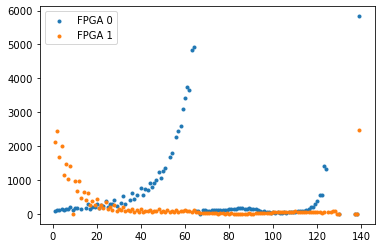

In [10]:
import matplotlib.pyplot as plt

TCSs0 = data[data["FPGA"] == 0]['TDC_CHANNEL'].value_counts()
TCSs1 = data[data["FPGA"] == 1]['TDC_CHANNEL'].value_counts()

plt.scatter(TCSs0.index, TCSs0.values, marker = '.', label = 'FPGA 0')
plt.scatter(TCSs1.index, TCSs1.values, marker = '.', label = 'FPGA 1')
plt.legend()
plt.show()

In [11]:
noisy_channels = [1,1,1]

dictionary = data.groupby(["TDC_CHANNEL"]).groups

for key in dictionary:
    if dictionary[noisy_channels[0]].shape[0] < dictionary[key].shape[0]:
        noisy_channels[2] = noisy_channels[1]
        noisy_channels[1] = noisy_channels[0]
        noisy_channels[0] = key
    
noisy_channels

[139, 64, 63]

In [12]:
orbits = len(data.groupby(["ORBIT_CNT"]).groups.keys())
orbits_with_139 = len(data[data["TDC_CHANNEL"] == 139].groupby(["ORBIT_CNT"]).groups.keys())

print(orbits)
print(orbits_with_139)

995
994
